# Links Para Artigos Relacionados


SSAST: Self-Supervised Audio Spectrogram Transformer [Link](http://https://arxiv.org/abs/2110.09784)

Audio representations for deep learning in sound synthesis: A review [Link](https://arxiv.org/abs/2201.02490)

Audio super-resolution via vision transformer [Link](https://link.springer.com/article/10.1007/s10844-023-00833-w)

Git ViT Super-Resolution  [GitHub](https://github.com/simona-nistico/ViT-SR)

# Variaveis

In [1]:


fma_small_path = '/kaggle/input/fma-free-music-archive-small-medium/fma_small/fma_small'
fma_medium_path = '/kaggle/input/fma-free-music-archive-small-medium/fma_medium'

input_test_path = "/kaggle/input/teste1"
output_path = r'/kaggle/working/output'

train_path = r"dataset/2024_AUDIOS_PROJETO_LARINGE/SEM_TRAQUEOSTOMIA/DALLETE_FONO"

# Importes

In [2]:
from main.pre_processamento.spectograma import redimensionar_audio_para_tamanho_original
from main.utils.gerar import info_audio

import torch.nn as nn

import soundfile as sf

from main.data_loader.LE import LE_Dataset, collate_fn
from main.config import batch_size

from transformers import AdamW

import torch
import numpy as np
from matplotlib import pyplot as plt
from main.arquitetura.auto_encoder.modelo.auto_encoder import GenerativeNetworkAuto


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

CUDA_VISIBLE_DEVICES=7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Thu Feb 13 08:41:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   54C    P8             16W /  170W |     984MiB /  12288MiB |     13%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Pre-processamento

Transformar audios m4a para mp3

# DataLoader 
Transforma o audio em np.array

In [4]:
def criar_dataloader(dataset, batch_size, collate_fn=None):
    data_generator = torch.Generator(device='cpu')
    data_generator.manual_seed(13)
    dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=False,
        generator=data_generator,
        collate_fn=collate_fn
    )
    return dataloader


CVMPT

In [5]:
from main.data_loader.CVMPT import CV_mozilla_PT_Dataset

trains_cvm = CV_mozilla_PT_Dataset(
    r"C:\Users\USER\Documents\Mestrado\codigo\Mestrado_VC\dataset\cv-corpus-mozilla-pt\pt", 
    path_duracoes_tsv_csv="dataset/cv-corpus-mozilla-pt/pt/clip_durations.tsv",
    ext='mp3',
    segundos=5
)

vals_cvm = CV_mozilla_PT_Dataset(
    r"C:\Users\USER\Documents\Mestrado\codigo\Mestrado_VC\dataset\cv-corpus-mozilla-pt\pt", 
    path_duracoes_tsv_csv="dataset/cv-corpus-mozilla-pt/pt/clip_durations.tsv",
    ext='mp3',
    segundos=5,
    validacao=True
)

print("Tamanho Treinamento:",trains_cvm.__len__())
print("Tamanho validaçao:",vals_cvm.__len__())


train_CVM = criar_dataloader(trains_cvm,1,collate_fn=collate_fn)
valid_CVN = criar_dataloader(vals_cvm,1,collate_fn=collate_fn)

******* Calculando índices das fatias *******


100%|██████████| 170991/170991 [00:00<00:00, 516935.64it/s]


******* Calculando índices das fatias *******


100%|██████████| 19000/19000 [00:00<00:00, 441880.24it/s]

Tamanho Treinamento: 45632
Tamanho validaçao: 5047


LE

In [6]:

from main.data_loader.LE import collate_fn_batch

path_natural = "dataset/2024_AUDIOS_PROJETO_LARINGE/SEM_TRAQUEOSTOMIA/DALLETE_FONO/NATURAL_MP3"
path_eletronica = "dataset/2024_AUDIOS_PROJETO_LARINGE/SEM_TRAQUEOSTOMIA/DALLETE_FONO/LARINGE_ELETRONICA_MP3"

train_ds = LE_Dataset(path_natural,path_eletronica, 'mp3')
val_ds = LE_Dataset(path_natural,path_eletronica, 'mp3', validacao=True)

#train
trainloader = criar_dataloader(train_ds, batch_size, collate_fn=collate_fn_batch)

#val
validloader = criar_dataloader(val_ds, batch_size, collate_fn=collate_fn_batch)



## AutoEncoder

In [7]:
# Models
generator = GenerativeNetworkAuto(device)
#discriminator = DiscriminativeNetwork(device).to(device)

# Optimizers
optimizer_gen = AdamW(generator.parameters(), lr=1e-4)#, weight_decay=1e-4) 
#optimizer_dis = torch.optim.Adam(discriminator.parameters(), lr=1e-5) 

# Loss
# pix2pix
loss_gen = nn.MSELoss()
loss_dis = nn.BCELoss()

C:\Users\USER\Documents\Mestrado\codigo\Mestrado_VC\.venv\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [8]:
from main.arquitetura.auto_encoder.modelo.auto_encoder import GenerativeNetworkAuto
generator_load = GenerativeNetworkAuto()
generator_load.load_state_dict(torch.load(
    'main/arquitetura/auto_encoder/pesos/generator_CVMPT_retirada_ruido_v2_best.pt',
    map_location=torch.device(device),
    weights_only=True
    ))
generator_load.to(device)
loss_gen = nn.L1Loss()

# Treinamento

LE

In [11]:

from main.arquitetura.auto_encoder.fit.treinamento.LE import train_autoencoder_laringe
loss_gen = nn.L1Loss()
train_autoencoder_laringe(
    generator_load, loss_gen, optimizer_gen,  10 , trainloader, device,"LE_com_pessos_pretreinados_CVMPT"
)

Epocas : 1 / 10 


100%|██████████| 34/34 [00:07<00:00,  4.32it/s]


Melhor modelo salvo com loss 0.08978148549795151
Loss : 0.08978148549795151
Epocas : 2 / 10 


 65%|██████▍   | 22/34 [00:04<00:02,  4.65it/s]


KeyboardInterrupt: 

Pre-processamento dos audios

In [ ]:
((3.0 * 7 ) + 15.24) %24

CVMT

In [ ]:
from main.arquitetura.auto_encoder.fit.treinamento.CVMPT import train_autoencoder_mozilla_pt


generator_train = train_autoencoder_mozilla_pt(
    generator,
    loss_gen,
    optimizer_gen,
    20,
    train_CVM,
    device,
    "CVMPT_retirada_ruido_v2"
)

In [ ]:

from main.arquitetura.auto_encoder.fit.validacao.CVMPT import validacao
        
validacao(valid_CVN, generator,loss_gen,1,device )

# Testes

In [ ]:
# load the model from checkpoints
generator_load = GenerativeNetworkAuto()
generator_load.load_state_dict(torch.load(
    'main/arquitetura/auto_encoder/pesos/generator_LE_com_pessos_pretreinados_CVMPT_best.pt',
    map_location=torch.device("cpu"),
    weights_only=False
    ))
generator_load.to("cpu")

In [ ]:
from main.utils.gerar import spectograma_natural_eletronico_gerado_LE
from main.utils.visualizar import spectograma_3
audio_original = train_ds.__getitem__(0)
audio_original_tuple = (audio_original.audio_natural, audio_original.audio_eletronico)
na,el,gerado = spectograma_natural_eletronico_gerado_LE(audio_original_tuple,generator_load)

spectograma_3(el,gerado,na,['eletronica','Gerado','Natural Grown Truth'])


In [ ]:
from main.pre_processamento.audio import transformar_imagem_em_audio
from main.metricas.similaridade import plot_amplitude_spectrum_from_arrays

gerado_audio = transformar_imagem_em_audio(gerado,audio_original.audio_eletronico)

original_audio = transformar_imagem_em_audio(na,audio_original.audio_natural)

plot_amplitude_spectrum_from_arrays(original_audio,gerado_audio, 44000, 
                                     titulo="Espectro de Amplitude - Exemplo")

In [ ]:

def salva_audio(caminho:str,audio,sr):
    sf.write(caminho, audio, sr)
    Audio(caminho, rate=str(sr),autoplay=True)
    
a = transformar_imagem_em_audio(gerado,audio_original[1])
salva_audio("output/LE/LE_teste_gerado.wav",a,44000)

a = transformar_imagem_em_audio(el,audio_original[1])
salva_audio("output/LE/LE_teste_eletronico.wav",a,44000)

a = transformar_imagem_em_audio(na,audio_original[0])
salva_audio("output/LE/LE_teste_natural.wav",a,44000)

In [ ]:
from main.pre_processamento.audio import transformar_audio_np_em_wav
from IPython.lib.display import Audio

_, _, _, spectrogram_original = info_audio(audio_original)

audio_sem_ruido_red = redimensionar_audio_para_tamanho_original(audio_sem_ruido,spectrogram_original.shape)
generated= transformar_audio_np_em_wav(audio_sem_ruido_red,audio_original)

caminho= "output/original.wav"
sf.write(caminho, generated, sr)
Audio(caminho, rate=str(sr),autoplay=True)

In [ ]:

audio_com_ruido_red = redimensionar_audio_para_tamanho_original(audio_com_ruido,spectrogram_original.shape)
generated= transformar_audio_np_em_wav(audio_com_ruido_red,audio_original)

caminho= "output/noise.wav"
sf.write(caminho, generated, sr)
Audio(caminho, rate=str(sr),autoplay=True)


In [ ]:
audio_processado_red = redimensionar_audio_para_tamanho_original(audio_processado,spectrogram_original.shape)
generated= transformar_audio_np_em_wav(audio_processado_red,audio_original)

caminho= "output/generated.wav"
sf.write(caminho, generated, sr)
Audio(caminho, rate=str(sr),autoplay=True)

# Exemplos Didaticos

In [ ]:
from main.pre_processamento.spectograma import transformar_audio_np_em_spectograma, redimencionar_spectorgama

data_orginal = trains_cvm.__getitem__(0)
print(data_orginal[0].shape)

data = np.expand_dims(data_orginal[0], axis=0)

print(transformar_audio_np_em_spectograma(data).shape)

data = transformar_audio_np_em_spectograma(data)
data = redimencionar_spectorgama(data[0], image_size=1024)

print(data.shape)

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

axes[0].imshow(data, cmap='viridis', origin='lower')
axes[0].set_title("Redimensionado")

axes[1].imshow(transformar_audio_np_em_spectograma(data_orginal[0]), cmap='viridis', origin='lower')
axes[1].set_title("Original")

plt.show()

In [ ]:

from main.pre_processamento.audio import add_ruido_audio

audio, sr = trains_cvm.__getitem__(111)
add_ruido_audio(audio,sr,0.1,ruido="robotic")


In [ ]:
from main.utils.visualizar import spectograma_3, spectograma_CVMPT

index = 0
audio_original = np.expand_dims(train_ds.__getitem__(index)[0], axis=0)[0]

sr = train_ds.__getitem__(index)[1]
audio_sem_ruido, audio_com_ruido, audio_processado = spectograma_CVMPT(audio_original,sr, generator_load)

print(audio_sem_ruido.shape)
print(audio_com_ruido.shape)
print(audio_processado.shape)

spectograma_3(audio_com_ruido, audio_processado, audio_sem_ruido ,["Com Ruido (input)", "Gerada (Output)", "Original Sem ruido (Ground Truth)"]) 

In [ ]:

audio_original ,sr = trains_cvm.__getitem__(0)
print("Audio original",audio_original.shape)

phase, MIN, MAX, spectrogram_original = info_audio(audio_original)

print("mel_spec Original",spectrogram_original.shape)

mel_spec_resized = redimencionar_spectorgama(spectrogram_original,1024)
print("mel_spec_resized",mel_spec_resized.shape)

mel_spec_original_fake = redimensionar_audio_para_tamanho_original(mel_spec_resized,spectrogram_original.shape)
print("mel_spec_original_fake",mel_spec_original_fake.shape)

spectograma_3(spectrogram_original, mel_spec_resized,mel_spec_original_fake, ["","",""])

## 1. ANALISE DE FALA (SPEECH ANALYSIS)

Device set to use cuda:0


📜 **Transcrição com Whisper:**  Um amigo veio visitar.
✅ **Texto Corrigido:** Corrigir: Um amigo veio visitar.
🔡 **Representação Fonética (Fonemas):** (tensor([[[14.5307, -0.5665, -2.7576,  ..., -7.2398, -7.4764, -8.7999],
         [14.7436, -0.8224, -2.8111,  ..., -7.2154, -7.4814, -8.8414],
         [14.8571, -0.9091, -2.8755,  ..., -7.1778, -7.4565, -8.8562],
         ...,
         [14.8207,  0.2026, -2.8027,  ..., -7.3612, -7.8438, -8.7654],
         [14.9838,  0.1510, -2.8369,  ..., -7.4690, -7.8023, -8.8449],
         [14.9739,  0.1329, -2.8054,  ..., -7.4690, -7.8517, -8.8669]]]), None)


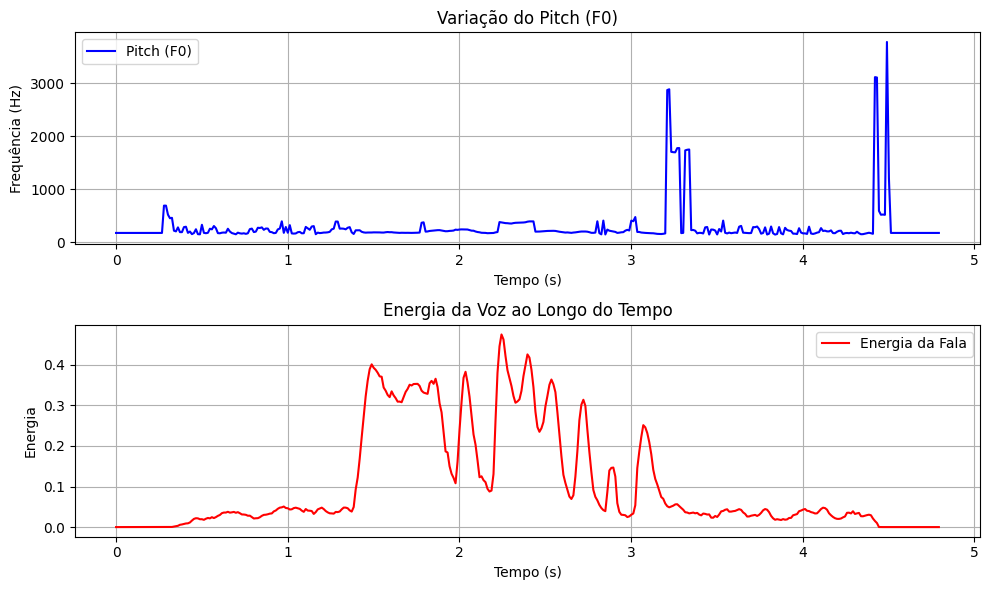

In [9]:
import whisper
import torch
import torchaudio
import librosa
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline
from torchaudio.pipelines import WAV2VEC2_ASR_BASE_960H
# Carregar arquivo de áudio (substitua 'audio.wav' pelo seu arquivo)
audio_path = 'output/audios_gerados/LE/LE_teste_natural.wav'



### MÉTODO 1: TRANSCRIÇÃO MELHORADA COM WHISPER ###
def transcrever_whisper(audio_path):
    modelo = whisper.load_model("small")  # Pode ser "tiny", "base", "small", "medium", "large"
    transcricao = modelo.transcribe(audio_path)["text"]
    return transcricao

### MÉTODO 2: CORREÇÃO DE TEXTO COM MODELO DE LINGUAGEM ###
def corrigir_texto(texto):
    corretor = pipeline("text2text-generation", model="t5-base")  # Modelo de correção de texto
    texto_corrigido = corretor(f"corrigir: {texto}", max_length=50)[0]['generated_text']
    return texto_corrigido

### MÉTODO 3: EXTRAÇÃO DE FONEMAS COM WAV2VEC 2.0 ###
def extrair_fonemas(audio_path):
    modelo_asr = WAV2VEC2_ASR_BASE_960H.get_model()  # Carrega modelo ASR
    waveform, sample_rate = torchaudio.load(audio_path)  # Carrega o áudio
    with torch.no_grad():
        transcricao_fonemica = modelo_asr(waveform)  # Converte fala para fonemas
    return transcricao_fonemica

### EXTRAÇÃO DE PITCH (F0) E ENERGIA DA FALA ###
def extract_pitch_energy(audio_path):
    y, sr = librosa.load(audio_path, sr=None)  # Carregar áudio

    # Calcular Pitch (F0) usando o método Yin
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)

    # Obter os valores de Pitch mais fortes
    pitch = []
    for i in range(pitches.shape[1]):  
        index = np.argmax(magnitudes[:, i])  # Índice da maior magnitude
        pitch_value = pitches[index, i]
        pitch.append(pitch_value if pitch_value > 0 else np.nan)  # Filtrar valores zero

    # Calcular Energia (intensidade da voz)
    energy = librosa.feature.rms(y=y)[0]

    return pitch, energy, sr, len(y) / sr

### EXECUÇÃO DOS MÉTODOS ###
texto_whisper = transcrever_whisper(audio_path)  # Método 1
texto_corrigido = corrigir_texto(texto_whisper)  # Método 2
fonemas = extrair_fonemas(audio_path)  # Método 3
pitch, energia, sr, duracao = extract_pitch_energy(audio_path)  # Extração de pitch e energia

### EXIBIR RESULTADOS ###
print("📜 **Transcrição com Whisper:**", texto_whisper)
print("✅ **Texto Corrigido:**", texto_corrigido)
print("🔡 **Representação Fonética (Fonemas):**", fonemas)

# Plot dos gráficos
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# Gráfico do Pitch
ax[0].plot(np.linspace(0, duracao, len(pitch)), pitch, label="Pitch (F0)", color='b')
ax[0].set_title("Variação do Pitch (F0)")
ax[0].set_ylabel("Frequência (Hz)")
ax[0].set_xlabel("Tempo (s)")
ax[0].legend()
ax[0].grid()

# Gráfico da Energia
ax[1].plot(np.linspace(0, duracao, len(energia)), energia, label="Energia da Fala", color='r')
ax[1].set_title("Energia da Voz ao Longo do Tempo")
ax[1].set_ylabel("Energia")
ax[1].set_xlabel("Tempo (s)")
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()


Taxa de amostragem original: 32000
Áudio reamostrado para: 16000 Hz
32000
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step


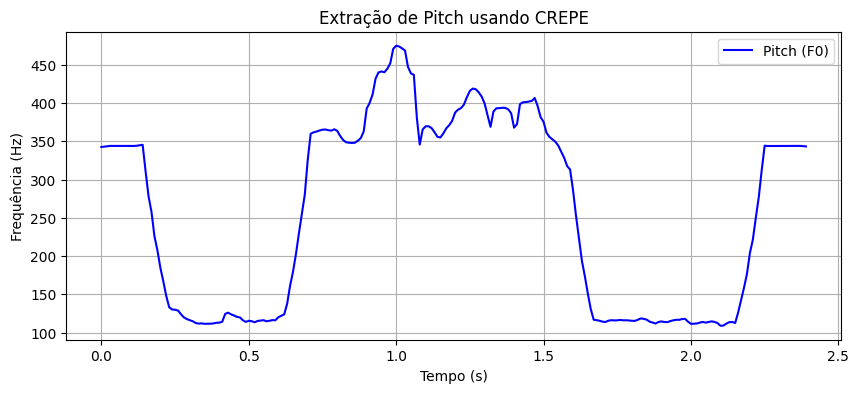

In [26]:
import crepe
import torch
import torchaudio
audio_path = 'output/audios_gerados/LE/LE_teste_natural.wav'
y, sr_orig = librosa.load(audio_path, sr=32000)
print("Taxa de amostragem original:", sr_orig)

# Reamostrar o áudio para 16000 Hz
target_sr = 16000
y_resampled = librosa.resample(y, orig_sr=sr_orig, target_sr=target_sr)
print("Áudio reamostrado para:", target_sr, "Hz")
    

# O CREPE trabalha diretamente com arquivos de áudio; podemos usar o arquivo original ou o áudio reamostrado.
# Aqui, usamos o arquivo 'audio.wav' com a taxa de amostragem correta (por exemplo, 16kHz ou 22050Hz, dependendo do áudio)
# (Se necessário, converta ou reamostre previamente para a taxa desejada para o CREPE.)
# Usando o método crepe.predict para extrair o pitch
print(sr)
time_crepe, frequency, confidence, activation = crepe.predict(y_resampled, sr=sr, viterbi=True)

# Plot dos resultados do pitch
plt.figure(figsize=(10, 4))
plt.plot(time_crepe, frequency, label='Pitch (F0)', color='b')
plt.xlabel('Tempo (s)')
plt.ylabel('Frequência (Hz)')
plt.title('Extração de Pitch usando CREPE')
plt.legend()
plt.grid(True)
plt.show()